## K-Shape Clustering

In [53]:
import warnings
warnings.filterwarnings("ignore")

from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
from pandas_datareader import data as pdr
import yfinance as yfin
import tslearn
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape

#### Test on some financial time series


In [23]:
# Download data sample
tickers = ["BTC-USD", "ETH-USD", "GOOG", "MSFT", "LINK-USD", "AAPL", "NFLX", "WMT", "KO"]
start_date = "2020-01-01"
end_date = "2022-12-31"

yfin.pdr_override()

fin_data = []
for i in tickers:
    data = pdr.get_data_yahoo(i, start=start_date, end=end_date, interval="1wk")['Close']
    fin_data.append(np.array([[x] for x in data]))

fin_data = np.array(fin_data)

## UNCOMMENT TO DOWNLOAD FULL DATASET
# btc_data = pdr.get_data_yahoo(tickers[0],  start=start_date, end=end_date, interval = "1wk")
# eth_data = pdr.get_data_yahoo(tickers[1],  start=start_date, end=end_date, interval = "1wk")
# goog_data = pdr.get_data_yahoo(tickers[2],  start=start_date, end=end_date, interval = "1wk")
# msft_data = pdr.get_data_yahoo(tickers[3],  start=start_date, end=end_date, interval = "1wk")

# Normalize data
X = fin_data
scaler = TimeSeriesScalerMeanVariance()
X = scaler.fit_transform(X)

# Save close data
btc_close = fin_data[0,:,:]
eth_close = fin_data[1,:,:]
goog_close = fin_data[2,:,:]
plnt_close = fin_data[7,:,:]
ko_close = fin_data[8,:,:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [24]:
# Initialize parameters for cluster
n_clusters = 4

# Compute model
model = KShape(n_clusters = n_clusters, verbose = False, n_init=15)
model.fit(X)
result = model.fit_predict(X)

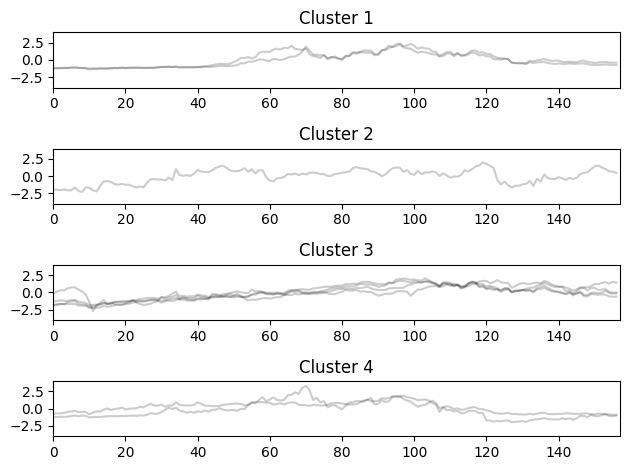

BTC-USD is in cluster 1
ETH-USD is in cluster 1
GOOG is in cluster 3
MSFT is in cluster 3
LINK-USD is in cluster 4
AAPL is in cluster 3
NFLX is in cluster 4
WMT is in cluster 2
KO is in cluster 3


In [ ]:
sz = X.shape[1]

plt.figure()
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, 1 + yi)
    for xx in X[result == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

for y in range(len(tickers)):
    print(tickers[y] + ' is in cluster ' + str(result[y] + 1))

Clustering looks good once the number of clusters is knwon in advance. Implement the Silhouette metric in order to identifie the number of clusters.
To do so, build the framework to compute intra and inter-cluster distance thorugh SBD.


0.10507016969792682


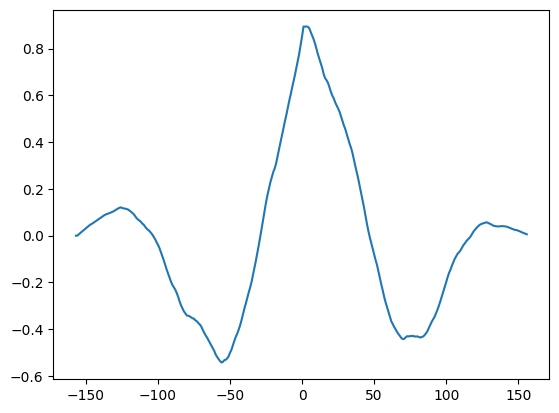

In [123]:
# Set default generator
rng = np.random.default_rng(123)
x = pd.DataFrame({'val':rng.random(10)})
y = pd.DataFrame({'val': rng.random(10)})

# compute argmax for the vector of autocorrelations
def ncc(x:pd.DataFrame, y:pd.DataFrame):
    '''Returns the normalized autocorrelation coeffiencent between two time series
    given all possible shifts'''
    autocorr = []
    normalizer = float(np.sqrt(np.dot(x.transpose(), x)*np.dot(y.transpose(), y)))
    for i in range(2*len(x)):
        shifted = np.nan_to_num(x.shift(-len(x)-1+i), copy = False)
        autocorr.append(np.dot(shifted.transpose(), y)[0][0]/normalizer)
    return autocorr

#check compution of sbd. Using the formula in ncc or selcting the autocorrealtions vector throug argmax should yield the same result
def sbd(x:pd.DataFrame, y:pd.DataFrame):
    '''Returns the Shape-based Distance between two time series according to the Gravano and
    Paparrizos (2015) definition using the normalized cross correlation coefficient'''
    autocorr = ncc(x,y)
    normalizer = float(np.sqrt(np.dot(x.transpose(), x)*np.dot(y.transpose(), y)))
    shift_opt = len(btc)-1-np.argmax(autocorr)
    shifted = np.nan_to_num(x.shift(shift_opt), copy = False)
    return 1 - autocorr[np.argmax(autocorr)]

btc = pd.DataFrame({'val': [float(x) for x in X[0]]})
eth = pd.DataFrame({'val': [float(x) for x in X[1]]})

autocorr = ncc(btc,eth)
start = len(btc)

plt.plot(np.arange(-len(btc),len(btc)),autocorr)

print(sbd(btc,eth))

In [ ]:
import numpy as np

def k_shape_clustering(X, K, n_init=10, max_iter=100):
    """
    K Shape Clustering algorithm implementation using normalized cross-correlation
    coefficient as the distance measure between time series.
    
    Parameters:
    -----------
    X : ndarray
        The input data as a N-dimensional array of shape (n_samples, n_features).
    K : int
        The number of clusters to create.
    n_init : int, optional (default=10)
        The number of times the algorithm will be run with different centroid initializations.
    max_iter : int, optional (default=100)
        The maximum number of iterations to run for each centroid initialization.
        
    Returns:
    --------
    labels : ndarray
        The cluster labels assigned to each input sample.
    centroids : ndarray
        The final centroid values of each cluster.
    """
    
    # Initialization
    n_samples, n_features = X.shape
    best_labels = None
    best_inertia = np.inf
    for i_init in range(n_init):
        # Initialize centroids randomly
        centroids = np.random.rand(K, n_features)
        for i_iter in range(max_iter):
            # Compute the normalized cross-correlation between each sample and each centroid
            distances = np.zeros((n_samples, K))
            for k in range(K):
                for i in range(n_samples):
                    corr = np.correlate(X[i], centroids[k], mode='valid')
                    distances[i, k] = 1 - corr / (np.sqrt(np.sum(X[i]**2)) * np.sqrt(np.sum(centroids[k]**2)))
            
            # Assign each sample to the closest centroid
            labels = np.argmin(distances, axis=1)
            
            # Compute the inertia of the current configuration
            inertia = np.sum(distances[np.arange(n_samples), labels]**2)
            
            # Update the centroids as the mean of the samples in each cluster
            for k in range(K):
                centroids[k] = np.mean(X[labels == k], axis=0)
            
            # Check if the algorithm converged to a better solution
            if inertia < best_inertia:
                best_inertia = inertia
                best_labels = labels.copy()
                best_centroids = centroids.copy()
                
    return best_labels, best_centroids